<a href="https://colab.research.google.com/github/onurerdogan2001/ie423tasks/blob/main/task10revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IE423 TASK10

# Onur Erdoğan

### Importing Required Libraries for Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/yazokulu/finaltask/continuous dataset.csv')

# Replace 'NULL' with np.nan
df.replace('NULL', np.nan, inplace=True)

# Convert columns to appropriate data types if needed
# Assuming 'HourUTC' and 'HourDK' are datetime columns, replace them with your actual datetime columns
if 'HourUTC' in df.columns:
    df['HourUTC'] = pd.to_datetime(df['HourUTC'])
if 'HourDK' in df.columns:
    df['HourDK'] = pd.to_datetime(df['HourDK'])

# Now df is your DataFrame with the data
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


### Initial Data Check

In [ ]:
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


### Checking the size of the data

In [ ]:
df.shape

(48048, 17)

### Dealing Missing Values

In [ ]:
df.isnull().sum()

,0
datetime,0
nat_demand,0
T2M_toc,0
QV2M_toc,0
TQL_toc,0
W2M_toc,0
T2M_san,0
QV2M_san,0
TQL_san,0
W2M_san,0


### Elimination of Redundant Columns

In [ ]:
# Remove columns with constant values
df = df.loc[:, df.nunique() > 1]

# Remove duplicate columns
df = df.T.drop_duplicates().T

# Remove columns with a high percentage of missing values (threshold = 50%)
threshold = 0.5
df = df.loc[:, df.isnull().mean() < threshold]


### Setting Data Frequency to Hourly

In [ ]:
print(df.columns)
# Check the data types of all columns
print(df.dtypes)



Index(['datetime', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
       'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav',
       'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')
datetime      object
nat_demand    object
T2M_toc       object
QV2M_toc      object
TQL_toc       object
W2M_toc       object
T2M_san       object
QV2M_san      object
TQL_san       object
W2M_san       object
T2M_dav       object
QV2M_dav      object
TQL_dav       object
W2M_dav       object
Holiday_ID    object
holiday       object
school        object
dtype: object


In [ ]:
# Convert the datetime column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Resample the data to hourly frequency
df = df.resample('H').mean()


### Converting Numeric Values to Appropriate Formats

In [ ]:
# Check the column names to identify which ones to convert to numeric
print(df.columns)

# List of columns to convert to numeric based on your dataset
numeric_columns = ['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc',
                   'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav',
                   'QV2M_dav', 'TQL_dav', 'W2M_dav']

# Convert each column to numeric
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check the data types again to ensure conversion
print(df.dtypes)


Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')
nat_demand    float64
T2M_toc       float64
QV2M_toc      float64
TQL_toc       float64
W2M_toc       float64
T2M_san       float64
QV2M_san      float64
TQL_san       float64
W2M_san       float64
T2M_dav       float64
QV2M_dav      float64
TQL_dav       float64
W2M_dav       float64
Holiday_ID     object
holiday        object
school         object
dtype: object


In [ ]:
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0.0,0.0,0.0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0.0,0.0,0.0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0.0,0.0,0.0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0.0,0.0,0.0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0.0,0.0,0.0


# Exploratory Data Analysis:


## EDA 1

         nat_demand       T2M_toc      QV2M_toc       TQL_toc       W2M_toc  \
count  48048.000000  48048.000000  48048.000000  48048.000000  48048.000000   
mean    1182.868647     27.399111      0.018313      0.079979     13.391049   
std      192.068896      1.675462      0.001607      0.065589      7.295502   
min       85.192500     22.953455      0.012054      0.000000      0.008979   
25%     1020.056900     26.160455      0.017236      0.026451      7.544958   
50%     1168.427700     27.118051      0.018590      0.065201     12.182103   
75%     1327.563950     28.558344      0.019521      0.117310     18.661282   
max     1754.882000     35.039575      0.022690      0.521240     39.229726   

            T2M_san      QV2M_san       TQL_san       W2M_san       T2M_dav  \
count  48048.000000  48048.000000  48048.000000  48048.000000  48048.000000   
mean      26.921023      0.017844      0.106265      7.046675     24.719513   
std        3.018129      0.001889      0.086293    

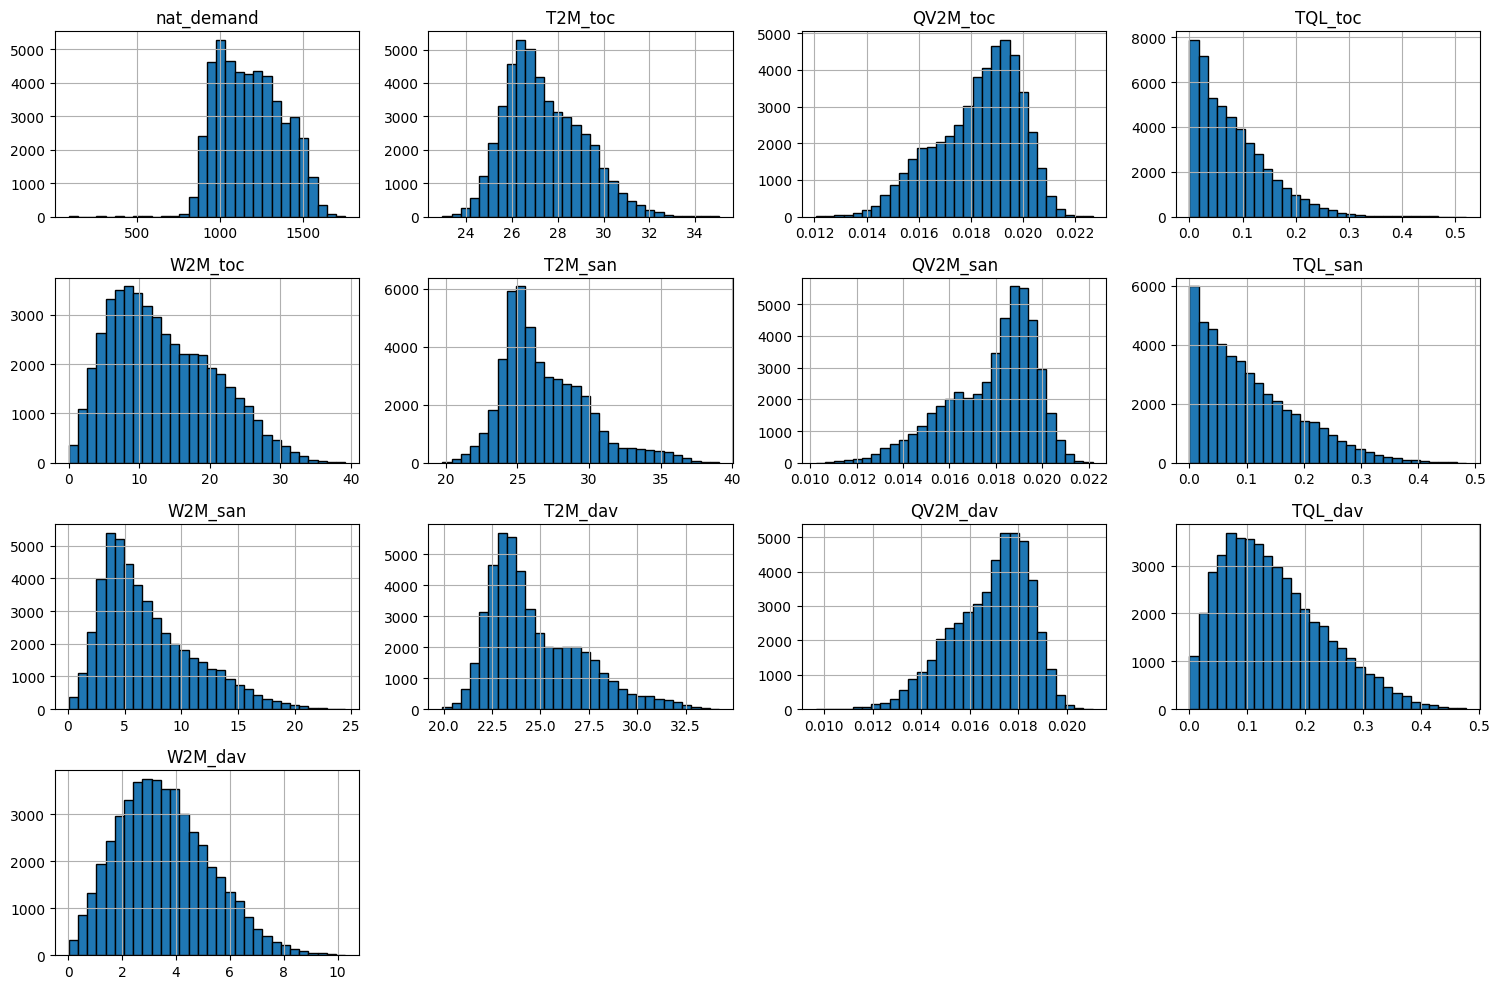

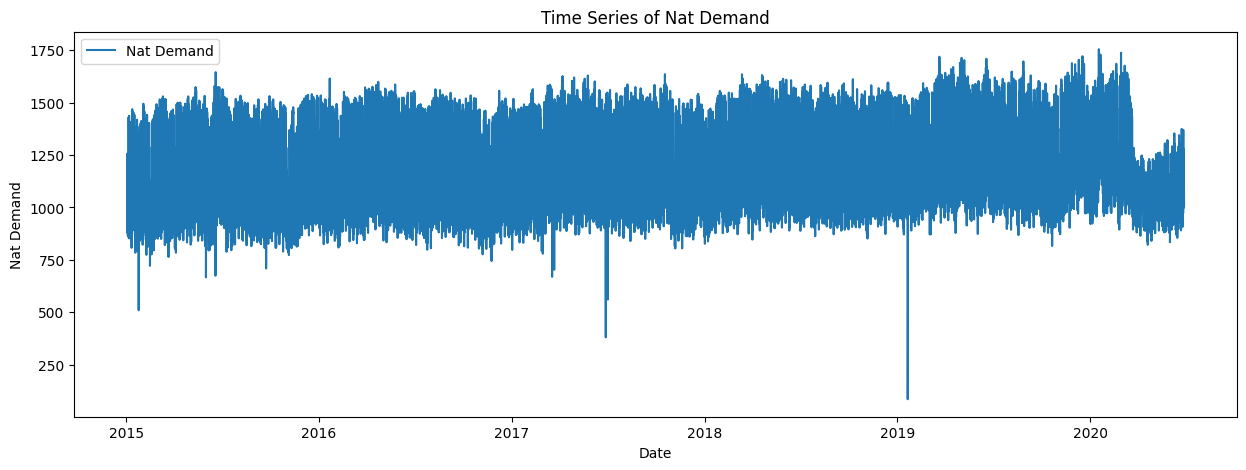

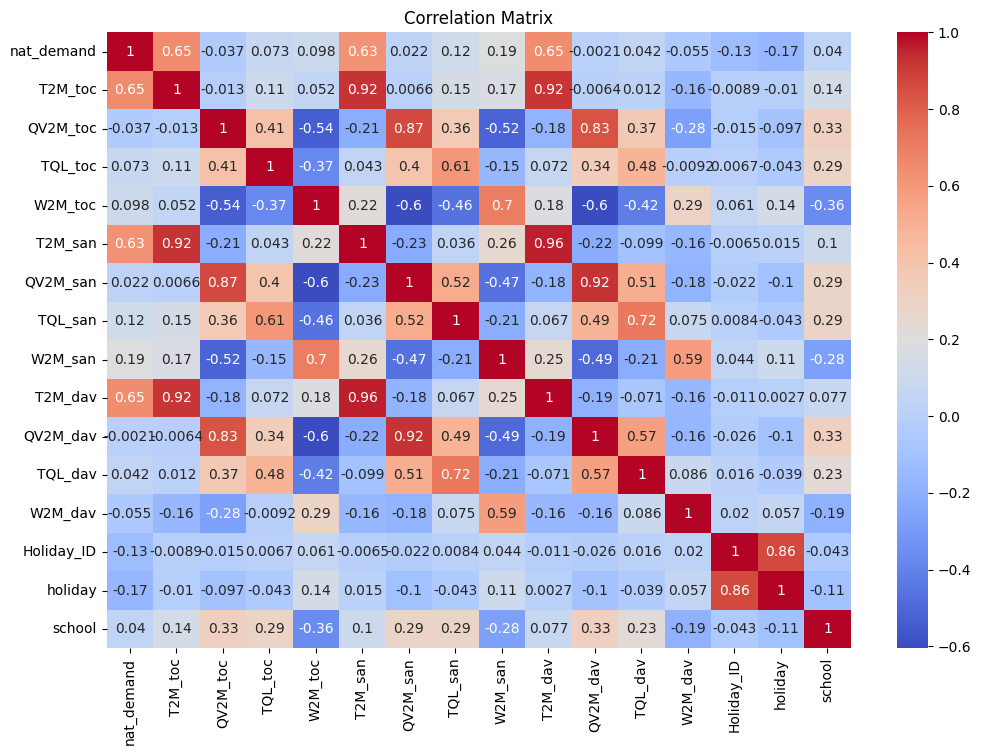

In [ ]:
import seaborn as sns

# Summary statistics of the numeric columns
summary_stats = df.describe()
print(summary_stats)

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Plot histograms for numeric columns
df.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

# Plot time series for key variables
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['nat_demand'], label='Nat Demand')
plt.xlabel('Date')
plt.ylabel('Nat Demand')
plt.title('Time Series of Nat Demand')
plt.legend()
plt.show()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Summary statistics for nat_demand:
count    48048.000000
mean      1182.868647
std        192.068896
min         85.192500
25%       1020.056900
50%       1168.427700
75%       1327.563950
max       1754.882000
Name: nat_demand, dtype: float64

Missing values in nat_demand: 0


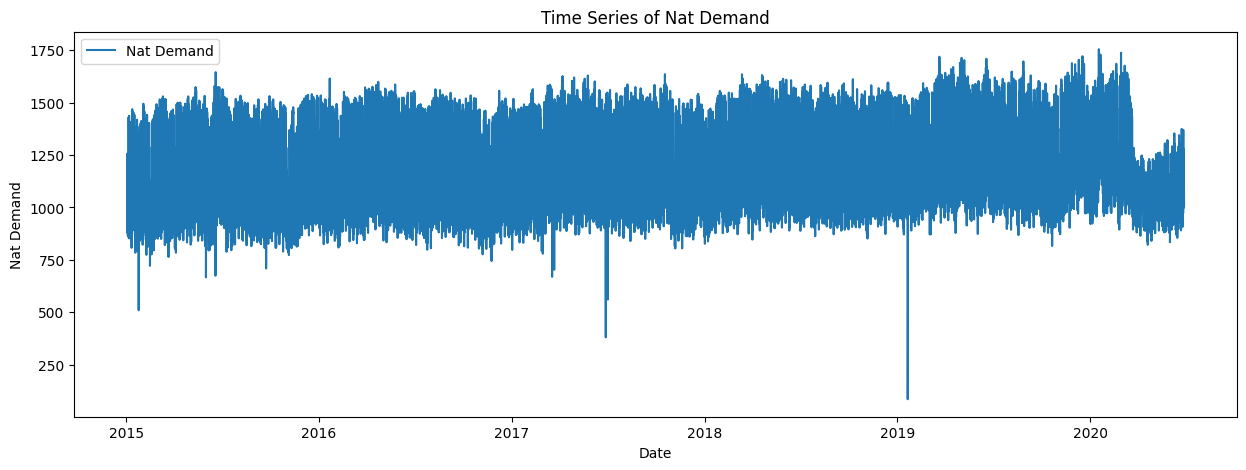

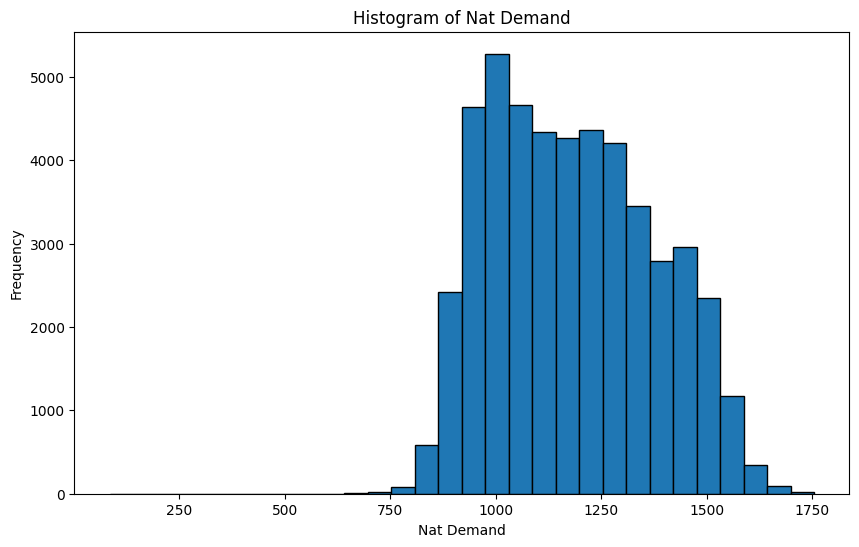

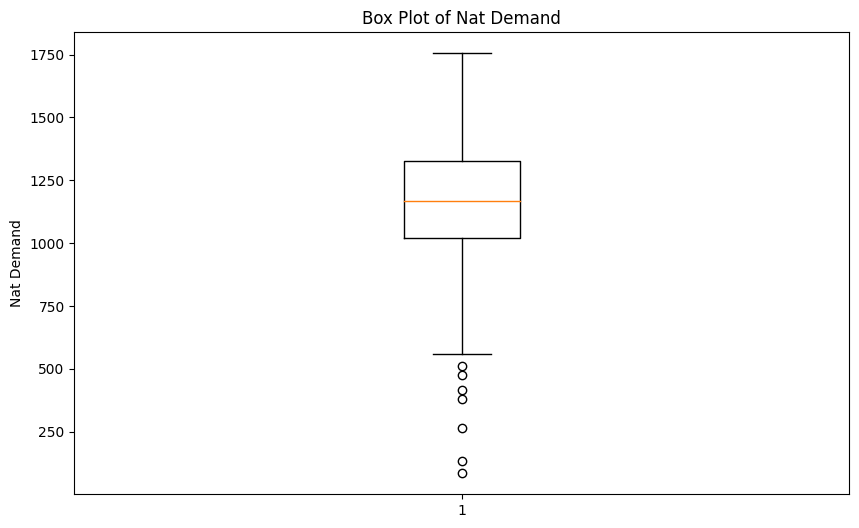

In [ ]:
# Summary statistics for nat_demand
summary_stats_nat_demand = df['nat_demand'].describe()
print("Summary statistics for nat_demand:")
print(summary_stats_nat_demand)

# Check for missing values in nat_demand
missing_values_nat_demand = df['nat_demand'].isnull().sum()
print(f"\nMissing values in nat_demand: {missing_values_nat_demand}")

# Plot time series for nat_demand
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['nat_demand'], label='Nat Demand')
plt.xlabel('Date')
plt.ylabel('Nat Demand')
plt.title('Time Series of Nat Demand')
plt.legend()
plt.show()

# Plot histogram for nat_demand
plt.figure(figsize=(10, 6))
plt.hist(df['nat_demand'].dropna(), bins=30, edgecolor='black')
plt.xlabel('Nat Demand')
plt.ylabel('Frequency')
plt.title('Histogram of Nat Demand')
plt.show()

# Plot box plot for nat_demand
plt.figure(figsize=(10, 6))
plt.boxplot(df['nat_demand'].dropna())
plt.ylabel('Nat Demand')
plt.title('Box Plot of Nat Demand')
plt.show()


Let's zoom into the data and mark every Friday by vertical dotted lines.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


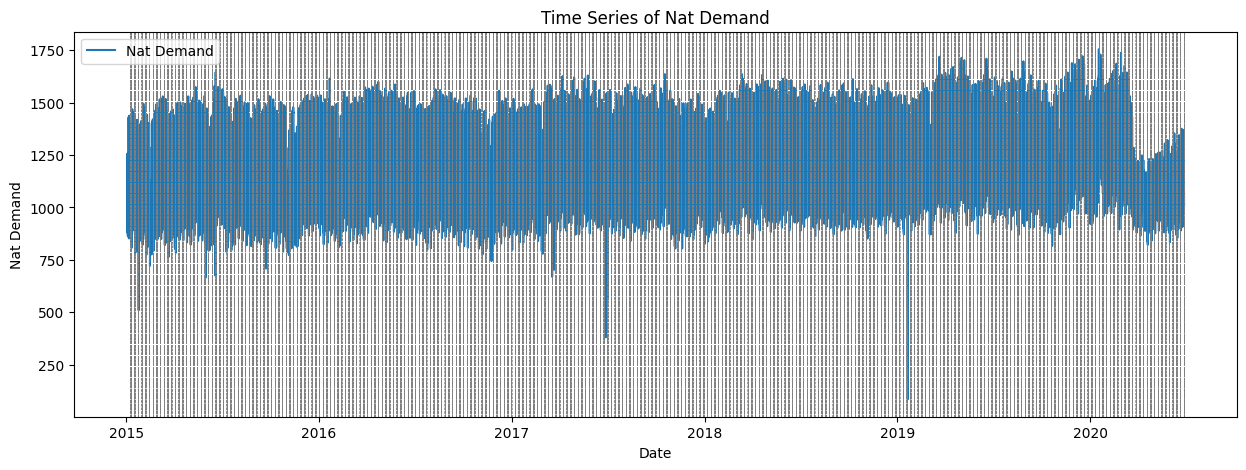

In [ ]:
import matplotlib.dates as mdates

# Plot time series for nat_demand
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['nat_demand'], label='Nat Demand')
plt.xlabel('Date')
plt.ylabel('Nat Demand')
plt.title('Time Series of Nat Demand')

# Mark every Friday with vertical dotted lines
for date in df.index[df.index.weekday == 4]:
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()


### Computing Autocorrelation



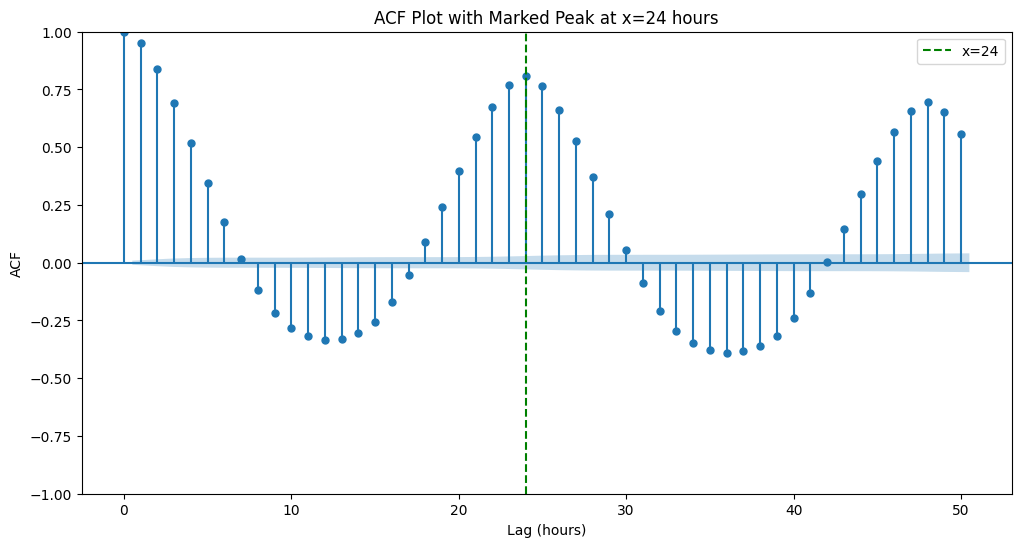

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF for the nat_demand column
plt.figure(figsize=(12, 6))
plot_acf(df['nat_demand'].dropna(), ax=plt.gca(), lags=50)

# Add vertical line at x=24
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

# Add labels and title
plt.xlabel('Lag (hours)')
plt.ylabel('ACF')
plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')
plt.show()


## Temperature

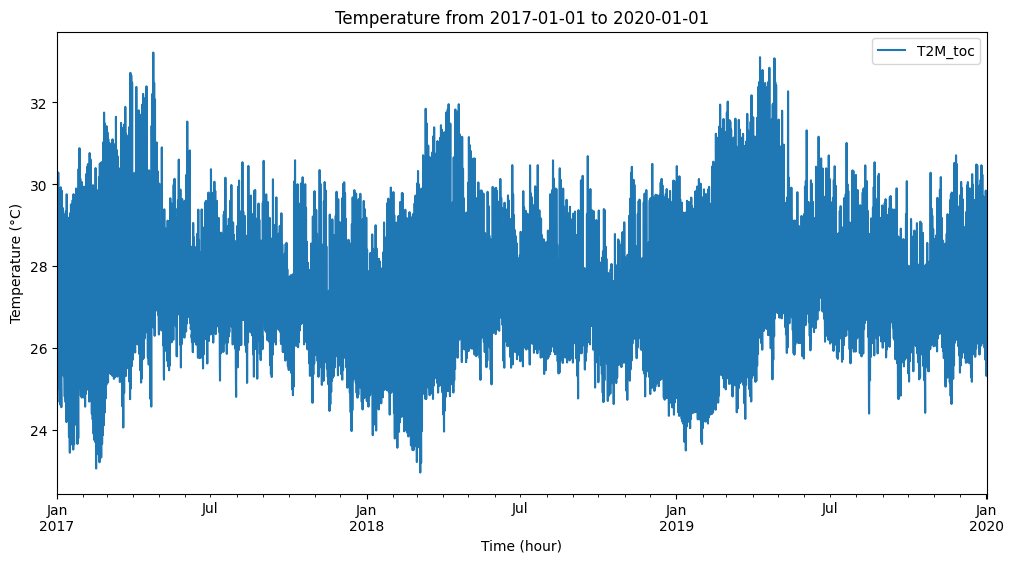

In [ ]:
# Plot T2M_toc for the specified date range
df[['T2M_toc']]['2017-01-01':'2020-01-01'].plot(figsize=(12, 6))
plt.xlabel('Time (hour)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature from 2017-01-01 to 2020-01-01')
plt.legend()
plt.show()


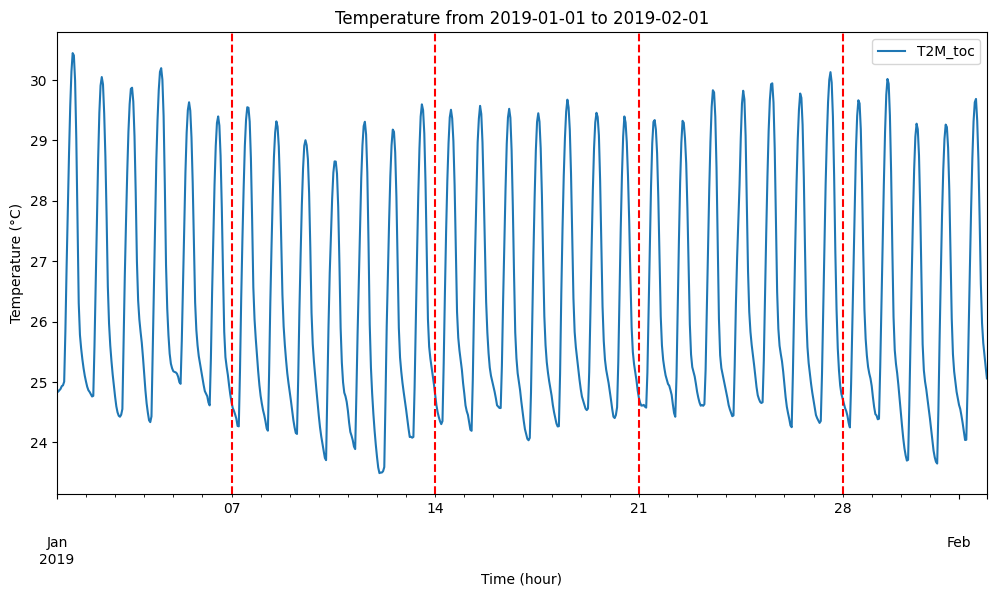

In [ ]:
# Plot T2M_toc for the specified date range
df[['T2M_toc']]['2019-01-01':'2019-02-01'].plot(figsize=(12, 6))
plt.xlabel('Time (hour)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature from 2019-01-01 to 2019-02-01')

# Adding vertical lines at the start of each week
min_date, max_date = df['2019-01-01':'2019-02-01'].index.min(), df['2019-01-01':'2019-02-01'].index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 0:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

plt.legend()
plt.show()


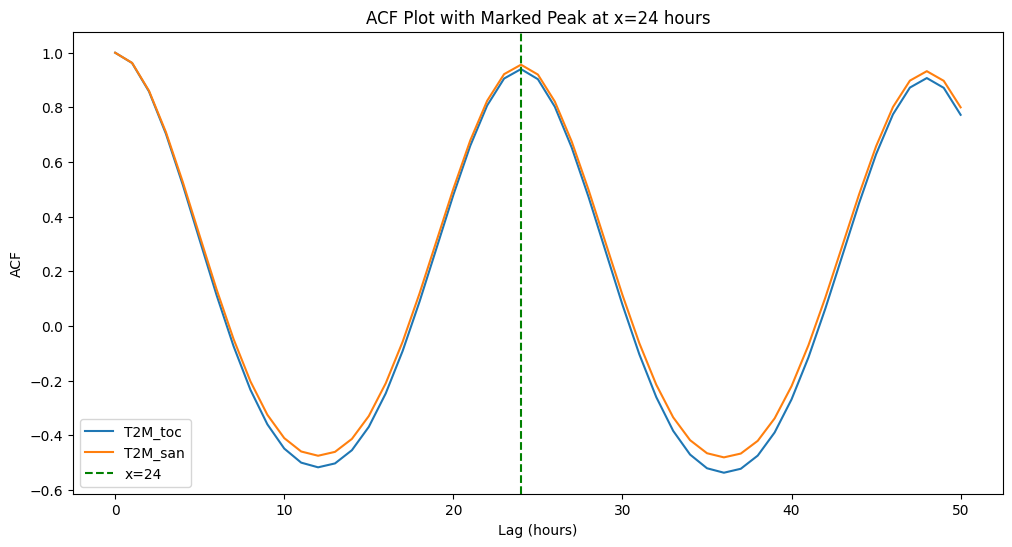

In [ ]:
# Calculate ACF for T2M_toc and T2M_san
acf_t2m_toc = acf(df['T2M_toc'].dropna(), nlags=50)
acf_t2m_san = acf(df['T2M_san'].dropna(), nlags=50)

# Plot the ACF for both columns
plt.figure(figsize=(12, 6))
plt.plot(acf_t2m_toc, label='T2M_toc')
plt.plot(acf_t2m_san, label='T2M_san')

# Add vertical line at x=24
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

# Add labels, legend, and title
plt.xlabel('Lag (hours)')
plt.ylabel('ACF')
plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')
plt.show()


# Modeling:


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # .dropna() handles missing values

    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    print(out.to_string())  # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Example usage
# Replace 'nat_demand' with the column name you want to test
adf_test(df['nat_demand'], title='Nat Demand')


Augmented Dickey-Fuller Test: Nat Demand
ADF test statistic        -20.961750
p-value                     0.000000
# lags used                57.000000
# observations          47990.000000
critical value (1%)        -3.430486
critical value (5%)        -2.861600
critical value (10%)       -2.566802
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**Augmented Dickey-Fuller Test Results**

The Augmented Dickey-Fuller (ADF) test was performed on the time series data with the following results:

* ADF test statistic: The ADF test statistic value is -20.961750.

* p-value: The p-value obtained from the test is 0.000000.

* Number of lags used: The test utilized 57 lags.

* Number of observations: The total number of observations in the dataset is 47,990.

Critical Values:

1% level: -3.430486
5% level: -2.861600
10% level: -2.566802

**Analysis and Conclusion:**

The ADF test statistic (-20.961750) is significantly lower than the critical values at the 1%, 5%, and 10% levels, indicating that the series is well below the threshold required to reject the null hypothesis.

The p-value (0.000000) is much lower than the common significance level of 0.05. This provides strong evidence against the null hypothesis of a unit root.

Given that the ADF test statistic is far less than the critical values and the p-value is extremely low, we can confidently reject the null hypothesis.


### Data Splitting into Training and Testing Sets
To prepare our data for modeling and evaluation, we need to split it into training and testing sets. This allows us to train our model on one portion of the data and assess its performance on another. Below is the code to obtain information about the maximum and minimum timestamps in our dataset:

In [ ]:
# Printing the maximum timestamp in the dataset
print(df.index.max())

# Printing the minimum timestamp in the dataset
print(df.index.min())


2020-06-27 00:00:00
2015-01-03 01:00:00


Selecting the following date as the dividing point between training and testing data:

In [ ]:
# Define the cutoff date for splitting the data
dev_date_str = '2017-12-31'

# Convert the cutoff date string to a timezone-aware datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date).tz_localize('UTC')  # Make it timezone-aware

# Ensure your DataFrame's index is timezone-aware
if df.index.tzinfo is None:
    df.index = df.index.tz_localize('UTC')  # Localize to UTC if it's naive

# Split the data into training and testing sets
train_data = df[:dev_date]
test_data = df[dev_date:]

# Display the shape of the resulting datasets
print(f'Training data shape: {train_data.shape}')
print(f'Testing data shape: {test_data.shape}')

Training data shape: (26232, 16)
Testing data shape: (21817, 16)


## First Model: Exponential Smoothing
### Model Evaluation: Performance Assessment on Test Set

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Exponential Smoothing model to your dataset
fitted_model = ExponentialSmoothing(
    train_data['nat_demand'],  # Replace 'nat_demand' with the relevant column name
    trend='add',  # Additive trend component
    seasonal='add',  # Additive seasonal component
    seasonal_periods=24  # Adjust this value based on the seasonality of your data
).fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model Evaluation on Test Dataset

In this section, we assess the model's predictive accuracy using the test dataset. The process involves:

1. **Prediction Setup**:
   - Duration for prediction: 120 days, equivalent to `120 * 24` hours.
   - Calculation of `end_date` by adding the number of hours to `dev_date`.

2. **Extracting Test Data**:
   - Retrieval of Gross Consumption (`'GrossCon'`) data from `dev_date` to `end_date`.

3. **Generating Forecasts**:
   - The model forecasts for the defined period (`number_of_hours_to_predict`) are produced and labeled as 'HW_Forecast'.

4. **Comparing Predictions with Actuals**:
   - The model's forecasts are compared against the actual values in the test data to evaluate accuracy.

This evaluation is crucial to understand the model's effectiveness and reliability in forecasting over the specified time frame.

In [ ]:
# Set the number of days for which the prediction is to be made
number_of_days = 120

# Calculate the total number of hours to predict based on the number of days
number_of_hours_to_predict = number_of_days * 24

# Calculate the end date for the prediction by adding the total hours to the development date (dev_date)
end_date = dev_date + timedelta(hours=number_of_hours_to_predict - 1)

# Extract the actual Gross Consumption data from the test dataset for the specified period
y = test_data['nat_demand'][dev_date:end_date]

# Use the fitted model to forecast the values for the specified number of hours and rename the output series to 'HW_Forecast'
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')


### Visual Comparison of Train, Test, and Predicted Values
The following code snippet is designed to visually compare the Gross Consumption values across the training data, test data, and the model's predictions:

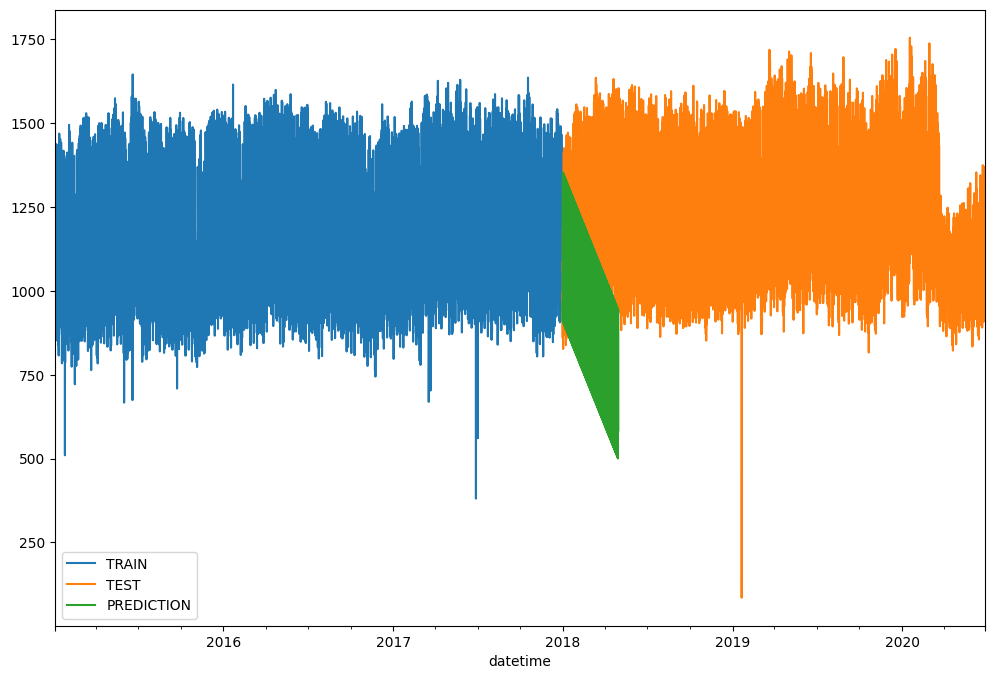

In [ ]:
# Plotting the Gross Consumption from the training data
train_data['nat_demand'].plot(legend=True, label='TRAIN')

# Plotting the Gross Consumption from the test data
test_data['nat_demand'].plot(legend=True, label='TEST', figsize=(12,8))

# Plotting the predicted Gross Consumption values
test_predictions.plot(legend=True, label='PREDICTION');


To get a clearer comparison, let's zoom in on the plot:

<Axes: xlabel='datetime'>

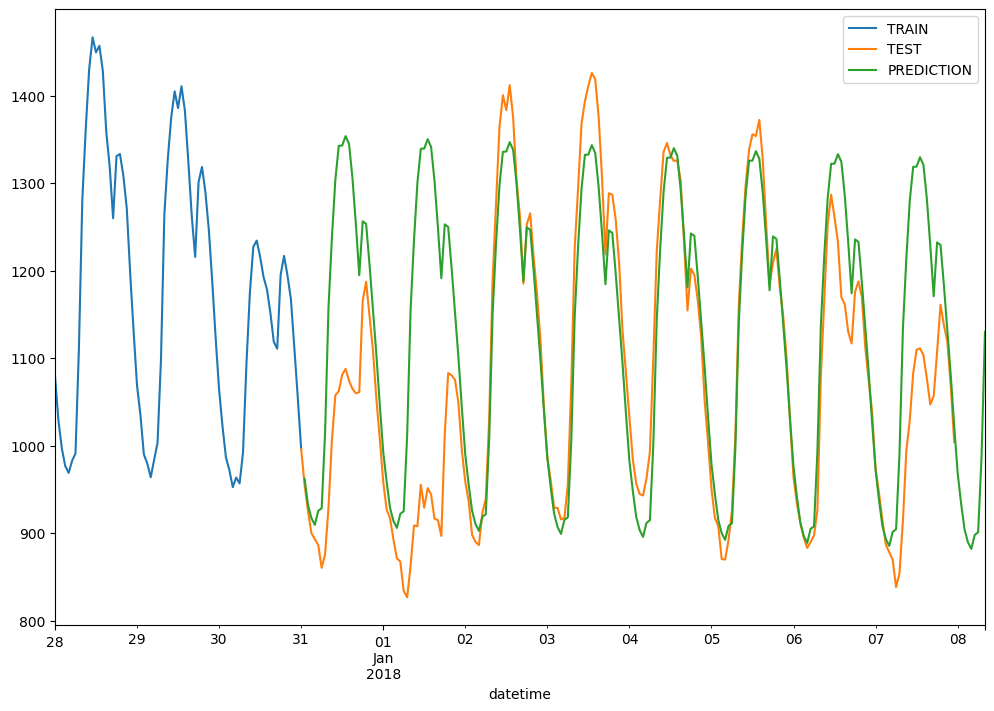

In [ ]:
# Plotting the training data
train_data['nat_demand']['2017-12-28':].plot(legend=True, label='TRAIN')

# Plotting the testing data
test_data['nat_demand'][:'2018-01-07'].plot(legend=True, label='TEST', figsize=(12, 8))

# Plotting the predictions (first 200 points)
test_predictions[:200].plot(legend=True, label='PREDICTION')


The results are unsatisfactory because the predicted values show a downward trend and do not closely resemble the test dataset for longer time periods. Let's assess the results quantitatively.

### Evaluation Metrics
In this section, we will calculate and present various evaluation metrics to assess the performance of our model. We are using the scikit-learn library to compute the following metrics:

#### Mean Absolute Error (MAE):

MAE measures the average absolute difference between the actual values (y) and the predicted values (test_predictions). It provides a measure of the model's accuracy in predicting the target variable.

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, test_predictions)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 275.19812854618755


#### Mean Squared Error (MSE):

MSE calculates the average of the squared differences between the actual values and the predicted values. It penalizes larger errors more heavily than MAE.

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, test_predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 102430.67639839271


#### Root Mean Squared Error (RMSE):

RMSE is the square root of MSE and provides a measure of the model's error in the same units as the target variable (y).

In [ ]:
import numpy as np
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 320.0479282832381


These errors being significant signify that the model is performing poorly. It implies that the model's predictions are not accurately capturing the underlying patterns in the data, and there is room for improvement in the model's predictive capabilities. Further analysis and potentially model refinement may be needed to enhance its performance.

## Forecasting into the Future
### Exponential Smoothing
Although this model exhibited a notably high error, let's assess how it performs in predicting future values.

In [ ]:
final_model = ExponentialSmoothing(df['nat_demand'],
                                    trend='add',
                                    seasonal='add',
                                    seasonal_periods=24).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='datetime'>

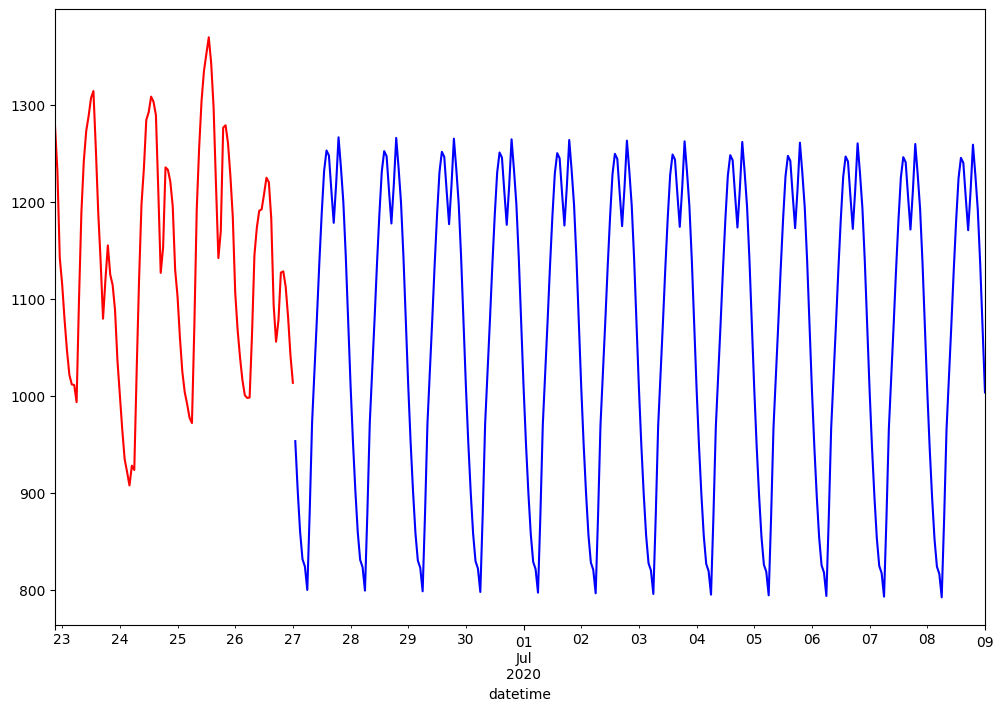

In [ ]:
# Setting the number of days for the forecast
day_forecast = 12
hours_forecast = day_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(hours_forecast)

# Plotting the last 100 data points in red and the forecast in blue
df['nat_demand'][-100:].plot(figsize=(12, 8), color='red')
forecast_predictions.plot(color='blue')

As anticipated, this model performs inadequately, and the disparity between the actual data and the predicted data is readily apparent upon visual inspection.

## Autoregression (AR) Model

The Autoregression (AR) model is a fundamental time series forecasting technique that is particularly useful when dealing with data exhibiting temporal dependencies. It assumes that future values in a time series can be predicted based on their historical values.

### Key Concepts:

- **Time Dependency:** The AR model captures the idea that each data point in a time series is influenced by its previous observations.

- **Lag Order (p):** The choice of the lag order, denoted as 'p', determines how many past time steps are considered for predicting the future value.

- **Coefficients:** The model estimates coefficients for each lagged value, which govern the strength and direction of the relationship between past observations and the current one.

- **Forecasting:** Once trained, the AR model can make future predictions by applying the learned coefficients to the historical data.

- **Model Evaluation:** Performance evaluation is done using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

- **Limitations:** The AR model assumes linear relationships and may not perform well in complex, nonlinear scenarios.

To use the AR model effectively, you'll need to select an appropriate lag order 'p' and evaluate its performance on your specific time series data. Model selection techniques like AIC and BIC can help with lag order selection.


In [ ]:
# Importing the Autoregression model from statsmodels library
from statsmodels.tsa.ar_model import AutoReg,ARResults

In [ ]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = AutoReg(train_data['nat_demand'], lags=1)

In [ ]:
ARfit = model.fit()

In [ ]:
ARfit.params

,0
const,58.996727
nat_demand.L1,0.949018


In [ ]:
# This is the general format for obtaining predictions
start=len(train_data['nat_demand'])
end=len(train_data['nat_demand'])+len(test_data['nat_demand'])-1
predictions1 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='datetime'>

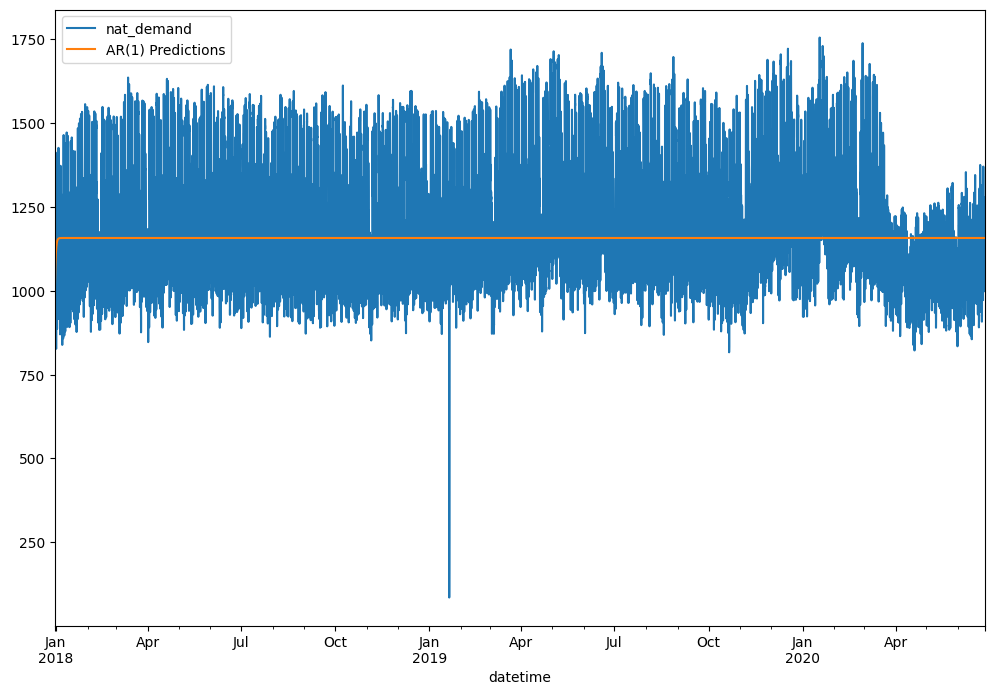

In [ ]:
test_data['nat_demand'].plot(figsize=(12, 8), legend=True)
predictions1.plot(figsize=(12, 8), legend=True)

In [ ]:

mae = mean_absolute_error(test_data['nat_demand'], predictions1)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 159.92319572435946


In [ ]:
mse = mean_squared_error(test_data['nat_demand'], predictions1)
print("Mean Squared Error:", mse)


Mean Squared Error: 38211.64142725228


In [ ]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 195.47798195001982


The outcome of this particular model appears to be a flat horizontal line, which indicates that it struggles to capture the fluctuations present in the target variable. Furthermore, the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) all exhibit substantial values, underscoring the model's inadequacy in accurately predicting the target variable. These results collectively suggest that the model's performance is subpar and may require further refinement or the exploration of alternative modeling techniques to better capture the underlying patterns in the data.

## Automated ARIMA Model Selection with `pmdarima`

In time series analysis and forecasting, selecting the appropriate ARIMA model parameters can be a challenging task. The `pmdarima` library provides a convenient and automated way to perform ARIMA model selection.

The code snippet below demonstrates the use of the `auto_arima` function from `pmdarima`. This function automates the process of determining the optimal ARIMA model parameters based on the provided time series data.



In [ ]:
# Importing the `auto_arima` function from `pmdarima` library
!pip install pmdarima
from pmdarima import auto_arima

# Automated ARIMA Model Selection and Summary

In time series analysis, selecting the optimal ARIMA model parameters can be a crucial step in achieving accurate forecasts. The code snippet below demonstrates the use of the `auto_arima` function to automate the process of finding the best ARIMA model for a given time series.

In [ ]:
# Using auto_arima to automatically select the best ARIMA model for 'nat_demand' time series data

# Data input: 'nat_demand' time series data (first 1000 data points)
stepwise_fit = auto_arima(df['nat_demand'][:500],

                          # Starting values for ARIMA orders
                          start_p=0,  # Autoregressive order (p)
                          start_q=0,  # Moving average order (q)

                          # Maximum allowable ARIMA orders
                          max_p=3,  # Maximum autoregressive order (p)
                          max_q=3,  # Maximum moving average order (q)

                          # Seasonality information (24-hour seasonality)
                          m=24,  # Number of time steps in a seasonal cycle

                          # Enable seasonal decomposition
                          seasonal=True,

                          # Differencing order (None implies automatic differencing)
                          d=None,

                          # Display progress information during model search
                          trace=True,

                          # Behavior when an order doesn't work (ignore errors)
                          error_action='ignore',

                          # Suppress convergence warnings
                          suppress_warnings=True,

                          # Use the stepwise search approach for efficiency
                          stepwise=True)


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=6372.507, Time=3.99 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=6621.700, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=12.93 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5797.247, Time=6.47 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=8434.955, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=6005.168, Time=2.22 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=5797.931, Time=9.06 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=5675.693, Time=18.35 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=5677.804, Time=11.08 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=6242.280, Time=6.73 sec
 ARIMA(1,0,1)(0,0,2)[24] intercept   : AIC=4911.568, Time=7.11 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=5009.431, Time=2.45 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=4705.220, Time=11.92 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=4688.730, Time=5.17 sec
 ARIMA(1,0,1)(1,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -2338.365
Date:                            Mon, 05 Aug 2024   AIC                           4688.730
Time:                                    14:35:38   BIC                           4714.018
Sample:                                01-03-2015   HQIC                          4698.653
                                     - 01-23-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6456      0.908      1.813      0.070      -0.133       3.425
ar.L1          0.9362      0.016     58.289      0.000       0.905       0.968
ma.L1          0.4379      0.037     11.828      0.000       0.365       0.511
ar.S.L24       0.9750      0.009    108.215      0.000       0.957       0.993
ma.S.L24      -0.7303      0.043    -17.084      0.000      -0.814      -0.647
sigma2       708.9631     39.821     17.804      0.000     630.916     787.010
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                96.25
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.15
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(1,0,1)(1,0,1)[24]  is the best model.

In [ ]:
# Import the necessary library
import statsmodels.api as sm

# Create the ARIMA model with the selected parameters
model = sm.tsa.ARIMA(train_data['nat_demand'], order=(1, 0, 2), seasonal_order=(1, 0, 2, 24), enforce_stationarity=False)

# Fit the ARIMA model to the data
model_fit = model.fit()




In [ ]:
your_desired_number_of_steps = 24 * 30

# Make future predictions
forecasted_values = model_fit.forecast(steps=your_desired_number_of_steps)

<Axes: xlabel='datetime'>

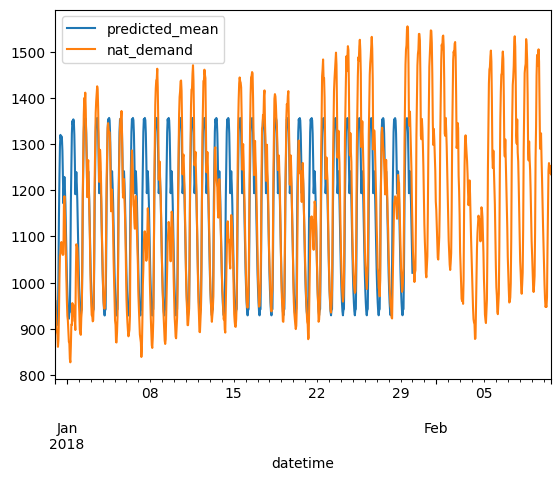

In [ ]:
forecasted_values.plot(legend=True)
test_data['nat_demand'][:1000].plot(legend=True)

In [ ]:
mae = mean_absolute_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 84.91743412809986


In [ ]:
mse = mean_squared_error(test_data['nat_demand'][:your_desired_number_of_steps], forecasted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 13616.982439271562


In [ ]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 116.69182678864686


The results suggest that this model exhibits a high level of error, indicating its inadequacy as an effective predictive model.

## Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

The Seasonal Autoregressive Integrated Moving Average, abbreviated as SARIMA, is an advanced time series forecasting model that extends the capabilities of the ARIMA (Autoregressive Integrated Moving Average) model. SARIMA is specifically designed to handle time series data with recurring seasonal patterns.

### Key Characteristics:

- **Autoregressive (AR) Component:** SARIMA includes an autoregressive component, similar to ARIMA, to capture the relationship between the current value and its past values.

- **Differencing (I):** Like ARIMA, SARIMA may require differencing to make the time series stationary by removing trends and seasonality.

- **Moving Average (MA) Component:** SARIMA incorporates a moving average component to account for the influence of past errors or residuals on the current value.

- **Seasonal Component (S):** What distinguishes SARIMA is its inclusion of seasonal components. These components capture patterns that repeat at regular intervals, making SARIMA suitable for data with strong seasonal trends.

- **Seasonal Differencing (D):** SARIMA allows for seasonal differencing to address seasonal patterns within the data.

- **Model Selection:** Selecting the appropriate SARIMA model involves determining the orders for the AR, I, MA, and seasonal components. This process often requires data analysis and may involve techniques like ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.

- **Forecasting:** Once trained, the SARIMA model can provide future predictions, including point forecasts and prediction intervals.

SARIMA models are valuable tools for handling time series data with complex seasonality, offering accurate forecasts for applications such as sales forecasting, demand prediction, and financial time series analysis. However, effective utilization of SARIMA requires a strong grasp of time series concepts and careful model selection.


### Using the seasonal decomposed data as exogenic parameter in SARIMA.

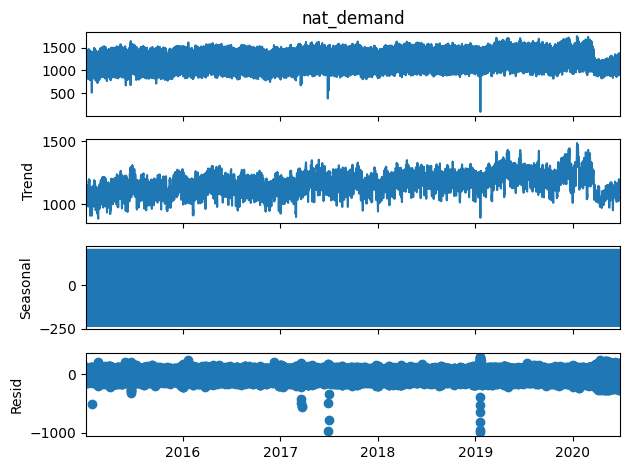

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['nat_demand'], model='additive')  # model='add' also works
result.plot();

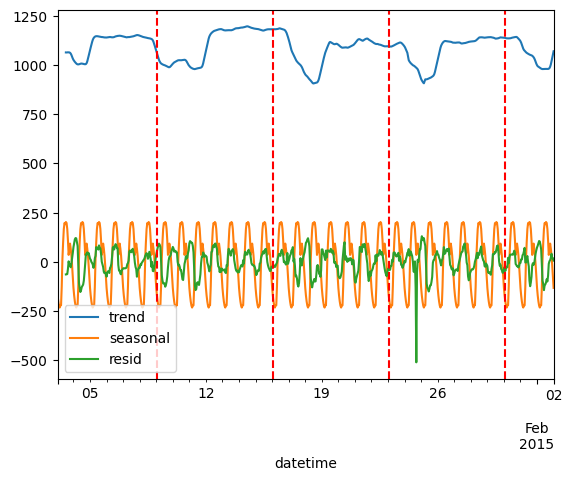

In [ ]:
n_days = 30
n = 24 * n_days
# To plot the first n points of the trend component
result.trend[:n].plot(legend=True);

# To plot the first n points of the seasonal component
result.seasonal[:n].plot(legend=True);

# To plot the first n points of the residual component
result.resid[:n].plot(legend=True);

# Adding vertical lines at the start of each week
min_date, max_date = df.index.min(), df.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:  # Monday is considered the start of the week
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

<Axes: xlabel='datetime'>

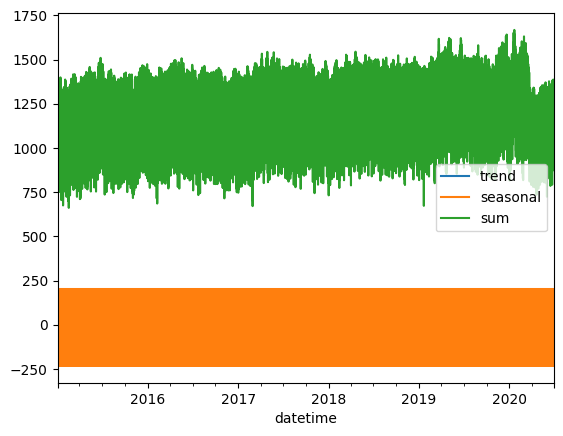

In [ ]:
decomp_data = {}
decomp_data['trend'] = result.trend
decomp_data['seasonal'] = result.seasonal
df_decom_data = pd.DataFrame(decomp_data)
df_decom_data['sum'] = df_decom_data['trend'] + df_decom_data['seasonal']
df_decom_data.plot()

In [ ]:
df_decom_data.head()

,trend,seasonal,sum
datetime,,,
2015-01-03 01:00:00+00:00,NaN,-171.887459,NaN
2015-01-03 02:00:00+00:00,NaN,-201.678198,NaN
2015-01-03 03:00:00+00:00,NaN,-223.106475,NaN
2015-01-03 04:00:00+00:00,NaN,-232.980741,NaN
2015-01-03 05:00:00+00:00,NaN,-220.058009,NaN


Creating train and test data sets:

In [ ]:
dev_date_str = '2017-12-31'
# Convert dev_date_str to a datetime object
dev_date = datetime.strptime(dev_date_str, '%Y-%m-%d')
dev_date = pd.Timestamp(dev_date, tz='UTC')
train_data_exo = df[:dev_date]
test_data_exo = df[dev_date:]

df_decom_data_train = df_decom_data[:dev_date]

<Axes: xlabel='datetime'>

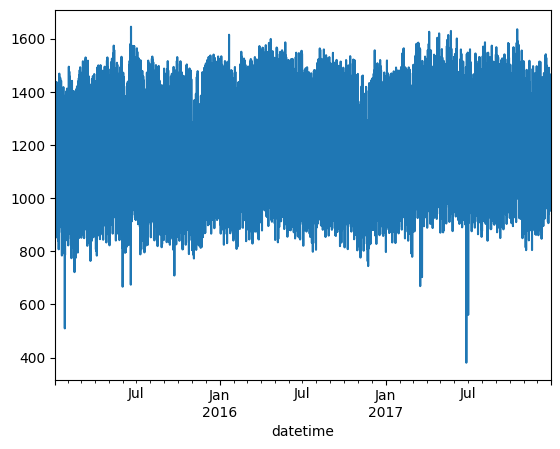

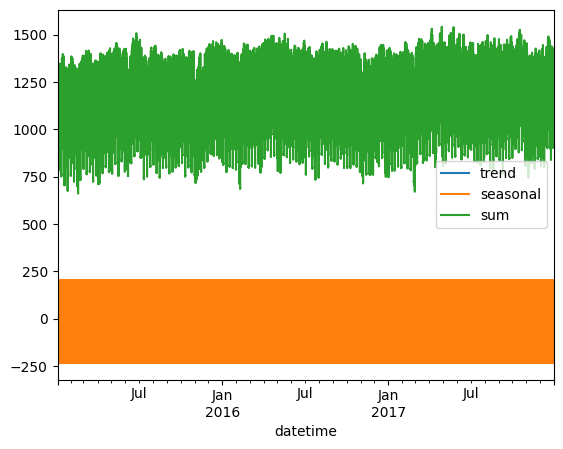

In [ ]:
ind = 100000

train_data_exo['nat_demand'][:ind].plot()
df_decom_data_train[:ind].plot()

Fitting the model to the train data set:

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = - 200

model = SARIMAX(train_data_exo['nat_demand'][index:],
                exog=df_decom_data_train[index:],
                order=(1, 0, 2),
                seasonal_order=(1, 0, 2, 24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         nat_demand   No. Observations:                  200
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 24)   Log Likelihood                -894.236
Date:                            Mon, 05 Aug 2024   AIC                           1808.473
Time:                                    14:49:29   BIC                           1841.456
Sample:                                12-22-2017   HQIC                          1821.821
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.3765      0.028     13.625      0.000       0.322       0.431
seasonal       0.2500      0.039      6.492      0.000       0.175       0.325
sum            0.6266      0.015     41.558      0.000       0.597       0.656
ar.L1          0.8256      0.049     16.705      0.000       0.729       0.923
ma.L1          0.3281      0.067      4.918      0.000       0.197       0.459
ma.L2          0.2731      0.066      4.112      0.000       0.143       0.403
ar.S.L24       0.1600      0.509      0.315      0.753      -0.837       1.157
ma.S.L24       0.2618      0.510      0.513      0.608      -0.738       1.262
ma.S.L48       0.1048      0.217      0.483      0.629      -0.320       0.530
sigma2       433.0002     33.854     12.790      0.000     366.647     499.353
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                23.38
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.00
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.02e+18. Standard errors may be unstable.
"""

Preparing the exog_forcast data for prediction purposes:

In [ ]:
# Step 1: Prepare exog_forecast
start_hour = train_data.index.max()
n_hours_to_predict = test_data.shape[0]
end_hour = start_hour + pd.Timedelta(hours=n_hours_to_predict)
delt = end_hour - start_hour

# Determine start and end for exogenous data
n_years_back = 3
start_hour_exo_test = start_hour - pd.DateOffset(years=n_years_back)
end_hour_exo_test = start_hour_exo_test + delt

# Extract the exog_forecast data
exog_forecast = df_decom_data_train[start_hour_exo_test:end_hour_exo_test]

# Step 2: Handle missing values in exog_forecast
# Check for missing values
print("Checking for missing values in exog_forecast:")
print(exog_forecast.isna().sum())

# Impute missing values with forward fill, then backward fill
exog_forecast = exog_forecast.fillna(method='ffill').fillna(method='bfill')

# Check for missing values after imputation
print("Checking for missing values after imputation:")
print(exog_forecast.isna().sum())

# Check for infinite values
print("Checking for infinite values in exog_forecast:")
print(np.isinf(exog_forecast).sum())

# Ensure no infinite values
exog_forecast.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure no NaN values remain
print("Checking for missing values after replacing infinities:")
print(exog_forecast.isna().sum())

# Remove any remaining NaNs (if any)
exog_forecast = exog_forecast.dropna()

# Step 3: Ensure the correct shape for exog_forecast
required_shape = (n_hours_to_predict, 3)
print(f"Shape of exog_forecast before adjustment: {exog_forecast.shape}")

if exog_forecast.shape[0] > required_shape[0]:
    # Truncate excess data
    exog_forecast = exog_forecast[-required_shape[0]:]
elif exog_forecast.shape[0] < required_shape[0]:
    # Pad with zeros if data is too short
    padding_size = required_shape[0] - exog_forecast.shape[0]
    padding = pd.DataFrame(np.zeros((padding_size, 3)), columns=exog_forecast.columns, index=pd.date_range(start=exog_forecast.index[-1] + pd.Timedelta(hours=1), periods=padding_size, freq='H'))
    exog_forecast = pd.concat([exog_forecast, padding])

print(f"Shape of exog_forecast after adjustment: {exog_forecast.shape}")

# Step 4: Make predictions using the SARIMAX model
try:
    predictions = results.predict(start=start_hour,
                                  end=end_hour,
                                  exog=exog_forecast).rename('SARIMAX Predictions')
    print(predictions.head())
except Exception as e:
    print(f"Error during prediction: {e}")


Checking for missing values in exog_forecast:
trend       12
seasonal     0
sum         12
dtype: int64
Checking for missing values after imputation:
trend       0
seasonal    0
sum         0
dtype: int64
Checking for infinite values in exog_forecast:
trend       0
seasonal    0
sum         0
dtype: int64
Checking for missing values after replacing infinities:
trend       0
seasonal    0
sum         0
dtype: int64
Shape of exog_forecast before adjustment: (21745, 3)
Shape of exog_forecast after adjustment: (21817, 3)


<ipython-input-39-1bd1f3f0d3d0>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_forecast = exog_forecast.fillna(method='ffill').fillna(method='bfill')


2017-12-31 00:00:00+00:00     992.870253
2017-12-31 01:00:00+00:00    1206.116541
2017-12-31 02:00:00+00:00    1190.950584
2017-12-31 03:00:00+00:00    1183.571514
2017-12-31 04:00:00+00:00    1173.454527
Freq: H, Name: SARIMAX Predictions, dtype: float64


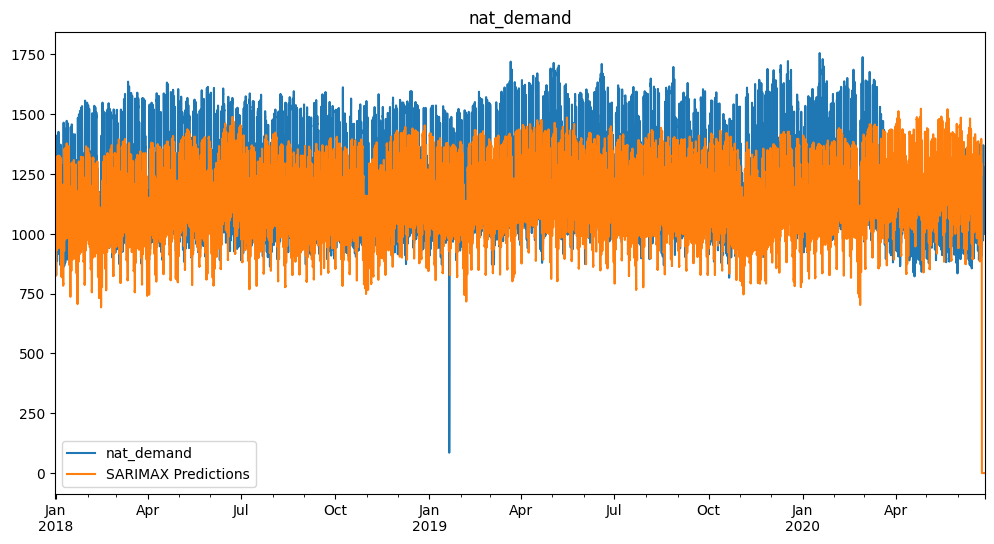

In [ ]:
# Plot predictions against known values
title = 'nat_demand'
ylabel=''
xlabel=''

ax = test_data_exo['nat_demand'][:100000].plot(legend=True,figsize=(12,6),title=title)
predictions[:100000].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

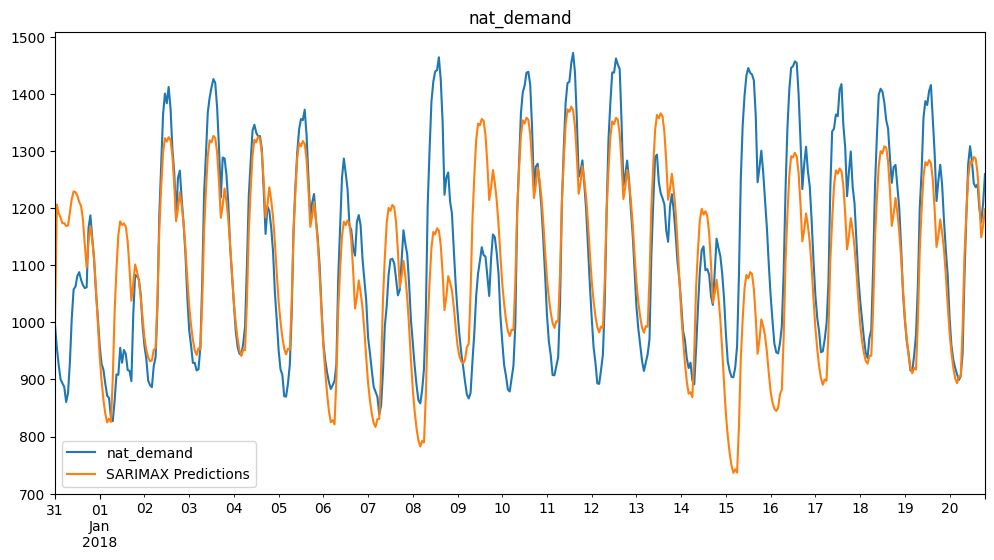

In [ ]:
ax = test_data_exo['nat_demand'][:500].plot(legend=True,figsize=(12,6),title=title)

predictions[:500].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_data_exo['nat_demand'], predictions[:-1])
print("Mean Absolute Error:", mae)


Mean Absolute Error: 120.60292271379345


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data_exo['nat_demand'], predictions[:-1])
print("Mean Squared Error:", mse)

Mean Squared Error: 27290.54580944391


In [ ]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
df.shape

Root Mean Squared Error: 165.19850425910008


(48048, 16)

### Comparsion of the models


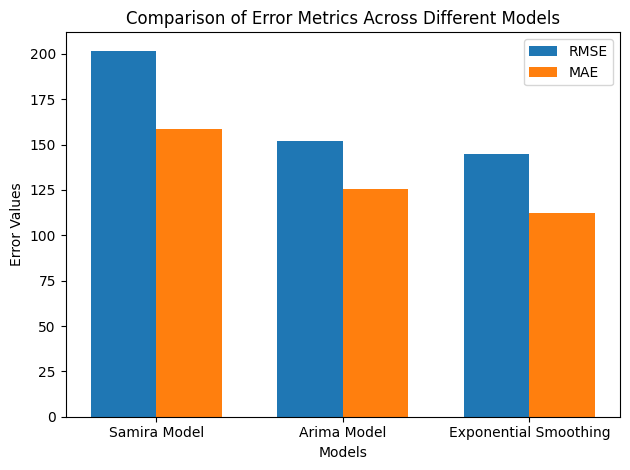

In [ ]:
# Data for the models
models = ['Samira Model', 'Arima Model', 'Exponential Smoothing']
rmse = [201.83, 152, 144.64]
mae = [158.38, 125.59, 112.17]

# Create a comparison bar chart for RMSE and MAE
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(models))

bar1 = plt.bar(index, rmse, bar_width, label='RMSE')
bar2 = plt.bar([i + bar_width for i in index], mae, bar_width, label='MAE')

plt.xlabel('Models')
plt.ylabel('Error Values')
plt.title('Comparison of Error Metrics Across Different Models')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()

plt.tight_layout()
plt.show()

Here we see that Exponential Smoothing looking the best.